# 疝气病症预测病马死亡率

本次实验使用Logistic回归、LDA与决策树分类器来分别预测患有疝病的马的存活问题，数据集中包含了368个样本和28个特征。数据集中包含了医院检测马疝病的一些指标，有的指标比较主观，有的指标难以测量，例如马的疼痛级别。另外需要说明的是，除了部分指标主观和难以测量外，该数据还存在一个问题，数据集中有30%的值是缺失的。首先在使用三个分类器预测病马的生死之前，需要处理数据集中的数据缺失问题。

## 任务1：数据预处理

* 导入相关包，读取列信息；
* 读入训练集，划分 x_data 与 y_data；
* 删除缺失较多的列，删除标签缺失的样本；
* 离散特征使用one-hot编码，用众数填充缺失值；
* 连续特征使用均值填充缺失值，并对所有连续特征进行minmax 归一化；
* 衡量所有特征之间的相关系数，进行PCA降维后得到x，再观察相关系数变化；
* 加载测试集，划分x_data_test与y_test，再进行上述数据预处理过程。

In [22]:
# 导入包
import pandas as pd
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 取得列信息
with open("resources/horse-colic.names", 'r', encoding='utf-8') as f:
    data_names = f.read()
data_columns = re.findall(r'(?<=[0-9]:).*', data_names)
data_columns = [col.strip() for col in data_columns[:-3]]
print(data_columns)

# one-hot编码列
col_oneHot = ['surgery?', 'Age']

['surgery?', 'Age', 'Hospital Number', 'rectal temperature', 'pulse', 'respiratory rate', 'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', "pain - a subjective judgement of the horse's pain level", 'peristalsis', 'abdominal distension', 'nasogastric tube', 'nasogastric reflux', 'nasogastric reflux PH', 'rectal examination - feces', 'abdomen', 'packed cell volume', 'total protein', 'abdominocentesis appearance', 'abdomcentesis total protein', 'outcome']


In [23]:
def load_data(data_path):
    horse_data = pd.read_csv(data_path, header=None, sep=r"\s+")
    horse_data = horse_data.loc[:, :22]  # 只取到死亡情况
    horse_data.columns = data_columns  # 修改列名
    horse_data = horse_data.replace("?", float('Nan')) #把问号替换为Nan

    return horse_data

def del_invalid(horse_data, NAN_THRES=0.5):
    col_del = ["Hospital Number"]  # 医院编号与存活率关系不大，选择删除
    # 去除缺失值占比较大的特征
    for col in horse_data.columns:
        if horse_data[col].isna().sum() > len(horse_data) * NAN_THRES and col not in col_del:
            col_del.append(col)
    
    return col_del

def preprocess(horse_data):
    # 调用drop函数，去除horse_data的outcome列
    x_data = horse_data.drop('outcome',1)
    y_data = horse_data[['outcome']]

    # outcome列修改，2（死亡）、3（被安乐死）均表示死亡，都以2表示；1表示存活
    y_data.loc[y_data['outcome'] == '3', 'outcome'] = '2'
    y_data['outcome'] = pd.to_numeric(y_data['outcome'], errors='coerce').astype('int32')

    # 分离离散列和连续列，分别处理
    x_discrete = x_data[list(set(col_oneHot))]
    x_continue = x_data.drop(columns=x_discrete.columns)

    # 离散特征one-hot编码
    for col in x_discrete.columns:
            column_onehot = pd.get_dummies(x_discrete[col], prefix=col)
            x_discrete = x_discrete.drop(columns=col)
            x_discrete = pd.concat([x_discrete, column_onehot], axis=1)

    # 离散特征用众数填补缺失值
    imp = SimpleImputer(strategy='most_frequent')
    x_discrete = pd.DataFrame(imp.fit_transform(x_discrete), columns=x_discrete.columns, index=None)
    for col in x_discrete.columns:
        x_discrete[col] = pd.to_numeric(x_discrete[col]).astype('int32')

    # 连续特征用均值填充缺失值
    for col in x_continue.columns:
        x_continue[col] = pd.to_numeric(x_continue[col], errors='coerce').astype("float64")
        # 使用x_continue[col]列的均值填充值为na的特征值
        x_continue[col] = x_continue[col].fillna(x_continue[col].mean()) #大写的T inplace=true不能写，否则缺失值填充不了
   
    # 对连续特征使用 minmax 归一化
    x_continue = (x_continue - x_continue.min())/(x_continue.max()-x_continue.min())
    #print(x_continue)

    x_data = pd.concat([x_discrete, x_continue], axis=1)

    x_data = x_data.sort_index(axis=1)  # 对列名排序，保证验证集和训练集特征一一对应

    return x_data, y_data

In [35]:
# 加载训练集
horse_data = load_data("resources/horse-colic.data")
# 删除缺失较多的列
col_del = del_invalid(horse_data)
horse_data = horse_data.drop(columns=col_del)
# 删除标签缺失的样本（存在na的样本）
horse_data = horse_data.dropna(subset=['outcome']).reset_index(drop=True) 
x_data, y_data = preprocess(horse_data)

x_data.info()
col_del

     rectal temperature     pulse  respiratory rate  \
0              0.574074  0.233766          0.227273   
1              0.703704  0.376623          0.136364   
2              0.537037  0.064935          0.181818   
3              0.685185  0.870130          0.863636   
4              0.351852  0.480519          0.306818   
..                  ...       ...               ...   
294            0.512707  0.584416          0.704545   
295            0.333333  0.272727          0.181818   
296            0.388889  0.272727          0.250000   
297            0.203704  0.454545          0.181818   
298            0.333333  0.064935          0.136364   

     temperature of extremities  peripheral pulse  mucous membranes  \
0                      0.666667          0.666667          0.370635   
1                      0.448560          0.340580          0.600000   
2                      0.000000          0.000000          0.400000   
3                      1.000000          0.000000      

['Hospital Number',
 'nasogastric reflux PH',
 'abdominocentesis appearance',
 'abdomcentesis total protein']

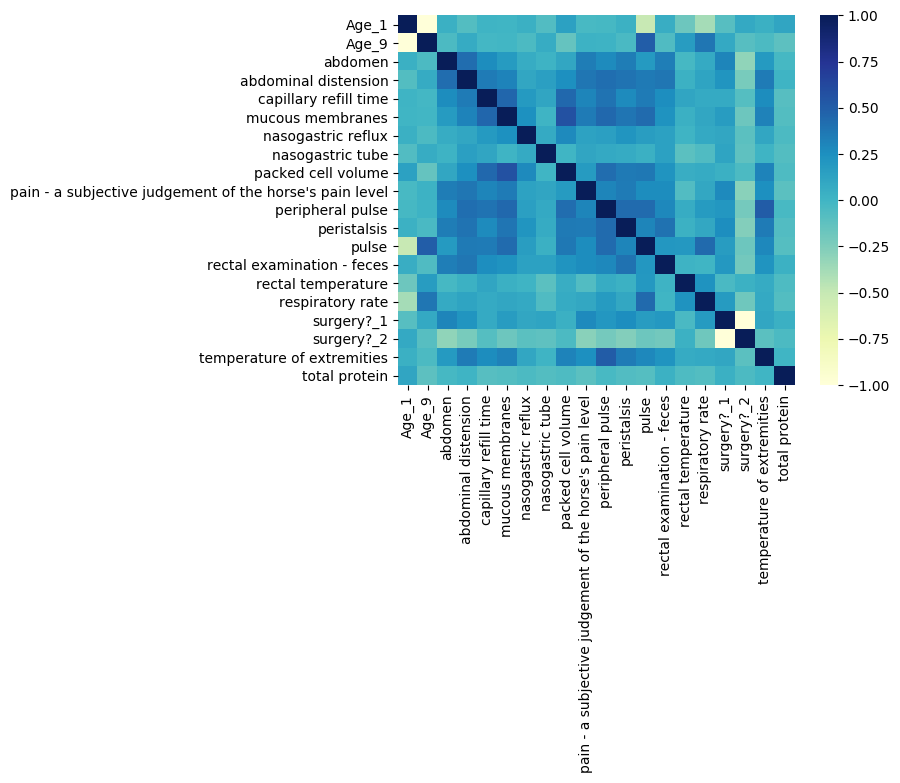

In [25]:
# 衡量特征之间相关系数
df_corr = x_data.corr()
sns.heatmap(df_corr, cmap="YlGnBu")

(299, 12)


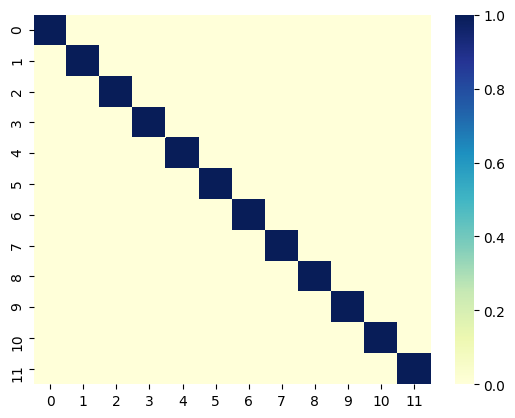

In [53]:
# PCA主成分分析，特征降维
# 调用PCA函数对x_data进行降维，生成12维特征的x
pca = PCA(n_components=12)
#print(x_data.isnull().any()) 判断是否有缺失值
x = pca.fit_transform(x_data) #fit or fit_transform?不过pca要中心化 fit的话一定要加上.components才行，否则pca object has no attribute shape,fit_transform之后就会变成ndarray，不能调用components_
#print(pca.components_.shape)
#print(x)
#print(pca.explained_variance_ratio_)
print(x.shape) #pca object has no attribute shape

# 相关系数
df_corr = pd.DataFrame(x, index=None).corr()
sns.heatmap(df_corr, cmap="YlGnBu")

In [54]:
# 测试集处理
data_test = load_data("resources/horse-colic.test")
# 删除缺失较多的列
data_test = data_test.drop(columns=col_del)
# 删除标签缺失的样本
data_test = data_test.dropna(subset=['outcome']).reset_index(drop=True)
x_data_test, y_test = preprocess(data_test)
# 将x_data_test进行PCA特征转换，生成x_test
x_test = pca.fit_transform(x_data_test)
print(x_test.shape)

    rectal temperature     pulse  respiratory rate  \
0             0.675676  0.172414          0.116279   
1             0.432432  0.120690          0.302326   
2             0.459459  0.086207          0.209302   
3             0.270270  0.189655          0.162791   
4             0.540541  0.068966          0.023256   
..                 ...       ...               ...   
62            0.702703  0.224138          0.232558   
63            0.486486  0.068966          0.348837   
64            0.540541  0.224138          0.023256   
65            0.540541  0.068966          0.023256   
66            0.432432  0.465517          0.302326   

    temperature of extremities  peripheral pulse  mucous membranes  \
0                     0.463277          0.000000               0.2   
1                     0.463277          0.245283               0.0   
2                     0.463277          1.000000               0.4   
3                     0.666667          0.000000               0.6   
4

## 任务2：模型训练与评估

* 导入相关包；
* 调用GridSearchCV函数，使用网格搜索法寻找最优参数penalty与C；
* 使用最优参数的逻辑回归模型进行训练，并对验证集进行预测与评估；
* 自定义逻辑回归函数MyLogisticRegression()，进行模型训练与预测，与上述结果比较；
* 调用sklearn中的LDA函数LinearDiscriminantAnalysis()，进行模型训练与预测，与上述结果比较；
* 调用sklearn中的决策树分类器函数DecisionTreeClassifier()，进行模型训练与测试，与上述结果比较。

In [55]:
# 导入包
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np

### 1、调用sklearn中的LogisticRegression函数实现逻辑回归分类

In [67]:
# 网格搜索
params_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C':  [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid = GridSearchCV(LogisticRegression(), param_grid=params_grid, cv=3, verbose=1) #don't forget () after logistic regression
# 对训练样本x与y进行模型超参数的网格搜索
grid.fit(x,y_data) #x
lgr_clf = grid.best_estimator_

# 逻辑回归模型训练
lgr_clf.fit(x,y_data)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.1s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
# 逻辑回归模型预测
print(lgr_clf.score(x_test, y_test))
y_pred_lgr = lgr_clf.predict(x_test)
print(classification_report(y_pred_lgr, y_test))

0.43283582089552236
              precision    recall  f1-score   support

           1       0.49      0.62      0.55        37
           2       0.30      0.20      0.24        30

    accuracy                           0.43        67
   macro avg       0.39      0.41      0.39        67
weighted avg       0.40      0.43      0.41        67



### 2、自定义逻辑回归函数MyLogisticRegression()，进行模型训练与预测，与上述结果比较。

### 3、调用sklearn中的LDA函数LinearDiscriminantAnalysis()，进行模型训练与预测，与上述结果比较。

In [70]:
# LDA线性判别分析
# 使用未进行PCA降维的20维特征x_data，进行模型训练
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit_transform(x_data,y_data) #弄清楚x,x_data,x_data_test,y, y_test是啥

# 模型测试
print(lda_clf.score(x_data_test, y_test))
y_pred_lda = lda_clf.predict(x_data_test)
print(classification_report(y_pred_lda, y_test))

0.7761194029850746
              precision    recall  f1-score   support

           1       0.83      0.85      0.84        46
           2       0.65      0.62      0.63        21

    accuracy                           0.78        67
   macro avg       0.74      0.73      0.74        67
weighted avg       0.77      0.78      0.77        67



### 4、调用sklearn中的决策树分类器函数DecisionTreeClassifier()，进行模型训练与测试，与上述结果比较。
首先分别使用经过PCA降维与未经过PCA降维的特征进行模型训练，比较结果；然后思考并尝试能够提高分类精度的策略。

In [74]:
# 决策树分类
# 使用未进行PCA降维的20维特征x_data, x_data_test，进行模型训练
dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(x_data,y_data)

# 模型测试
print(dtc_clf.score(x_data_test, y_test))
y_pred_dtc = dtc_clf.predict(x_data_test)
print(classification_report(y_pred_dtc, y_test))

# 使用进行PCA降维的12维特征x, x_test，进行模型训练
dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(x,y_data)

# 模型测试
print(dtc_clf.score(x_test, y_test))
y_pred_dtc = dtc_clf.predict(x_test)
print(classification_report(y_pred_dtc, y_test))

# 尝试能够提高分类精度的策略（选做）
# 请在下方作答


0.6417910447761194
              precision    recall  f1-score   support

           1       0.57      0.87      0.69        31
           2       0.80      0.44      0.57        36

    accuracy                           0.64        67
   macro avg       0.69      0.66      0.63        67
weighted avg       0.70      0.64      0.63        67

0.44776119402985076
              precision    recall  f1-score   support

           1       0.55      0.62      0.58        42
           2       0.20      0.16      0.18        25

    accuracy                           0.45        67
   macro avg       0.38      0.39      0.38        67
weighted avg       0.42      0.45      0.43        67

